In [1]:
#!pip install pandas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('data/train.csv')

---

### Expansion of Variables for EDA

In the following we are expanding our data frame to generate additional insights about our data. Looking at the `train.csv` file it becomes clear that for every defect (`ClassId`) there is a seperate line. This means also that if there is more than one defect on an image, there will be separate lines for the respective `ImageId`.

In [4]:
# Count occurrences of `ImageId` in df
df['count'] = df.ImageId.apply(lambda x: df['ImageId'].value_counts()[x])

In [5]:
df.head(7)

,ImageId,ClassId,EncodedPixels,count
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,2
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...,2


The `EncodedPixels` are encoded in the following way:

- columns are scanned from top to bottom (256 pixels per column)
- pixels are numbered from 1 to 409,600 (256 x 1600)
- the first number in `EncodedPixels` shows the start of a recognized defect in the image
- the second number in `EncodedPixels` number of consecutive pixels that belong to the recognized defect in the image

In the following we are looking at the size of defects in an image as total pixels the belong to the `ClassId` per `ImageId`.

In [6]:
def count_defect_pixels(EncodedPixels):
    sum = 0
    for idx, pixel in enumerate(EncodedPixels.split()):
        if idx%2 != 0:
            sum += int(pixel)

    return sum

In [7]:
df['DefectSizePixel'] = df.EncodedPixels.apply(lambda x: count_defect_pixels(x))
df.head()

,ImageId,ClassId,EncodedPixels,count,DefectSizePixel
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,4396
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1,6897
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1,8319
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1,69357
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1,4851


In [8]:
df.groupby('ClassId')['DefectSizePixel'].mean().reset_index()

,ClassId,DefectSizePixel
0,1,4361.347826
1,2,3378.425101
2,3,25496.485243
3,4,34373.997503


It becomes clear that, on average, defects of `ClassId` 3 and 4 are much bigger in size.

In [9]:
!pip3 install opencv-python

In [10]:
# Calculate fraction of defect relative to the picture size
import cv2

def get_image_height(image):
    image = cv2.imread('data/train_images/' + image) # read an image by its path
    return image.shape[0] # image.shape returns a tupel (height, width, depth)

def get_image_width(image):
    image = cv2.imread('data/train_images/' + image)
    return image.shape[1]

def get_image_depth(image):
    image = cv2.imread('data/train_images/' + image)
    return image.shape[2]

In [11]:
# Create columns for `Height`, `Width`, and `Depth`
df['Height'] = df.ImageId.apply(lambda x: get_image_height(x))
df['Width'] = df.ImageId.apply(lambda x: get_image_width(x))
df['Depth'] = df.ImageId.apply(lambda x: get_image_depth(x))

df['DefectSizePixelRelative'] = df.DefectSizePixel / (df.Height * df.Width)

In [12]:
df.head()

,ImageId,ClassId,EncodedPixels,count,DefectSizePixel,Height,Width,Depth,DefectSizePixelRelative
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,4396,256,1600,3,0.010732
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1,6897,256,1600,3,0.016838
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1,8319,256,1600,3,0.020310
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1,69357,256,1600,3,0.169329
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1,4851,256,1600,3,0.011843


In [13]:
# Check whether we have different dimensions for pictures
df.describe()

,ClassId,count,DefectSizePixel,Height,Width,Depth,DefectSizePixelRelative
count,7095.000000,7095.000000,7095.000000,7095.0,7095.0,7095.0,7095.000000
mean,2.825229,1.121494,23056.669626,256.0,1600.0,3.0,0.056291
std,0.789279,0.329302,34957.878108,0.0,0.0,0.0,0.085346
min,1.000000,1.000000,115.000000,256.0,1600.0,3.0,0.000281
25%,3.000000,1.000000,4251.000000,256.0,1600.0,3.0,0.010378
50%,3.000000,1.000000,10341.000000,256.0,1600.0,3.0,0.025247
75%,3.000000,1.000000,26791.000000,256.0,1600.0,3.0,0.065408
max,4.000000,3.000000,368240.000000,256.0,1600.0,3.0,0.899023


In [14]:
df.groupby('ClassId')['DefectSizePixelRelative'].mean().reset_index()

,ClassId,DefectSizePixelRelative
0,1,0.010648
1,2,0.008248
2,3,0.062247
3,4,0.083921


Relative defect size on average reaches up to 8.4% for defect class 4. As we can see above, however, the maximum coverage of a defect may reach **up to 89.9%** of the respective image.

Let's have a look at TOP5 and BOTTOM5 for `DefectSizePixelRelative`:

In [15]:
TOP5 = df.query('DefectSizePixelRelative > 0.7')[['ImageId','ClassId','DefectSizePixelRelative','count']]\
    .sort_values(by='DefectSizePixelRelative', ascending = False)[:5]

# save names of TOP5
TOP5_names = TOP5.ImageId.tolist()

In [16]:
# Cross-check whether TOP5 belongs to single defects or if there are mixed defects as well
df.groupby('ImageId').sum()[['DefectSizePixelRelative','count']]\
    .reset_index().sort_values(by='DefectSizePixelRelative', ascending=False)[:30]

,ImageId,DefectSizePixelRelative,count
1258,306415665.jpg,0.899023,1
6599,fda720bac.jpg,0.869893,1
5853,df5c68422.jpg,0.852310,1
1982,4d93e9c21.jpg,0.815776,1
3852,9438d5eef.jpg,0.802595,1
5241,c873d7724.jpg,0.772495,1
2805,6d08d7ab4.jpg,0.735330,1
5912,e1e0a91b8.jpg,0.719404,1
4414,a9f605949.jpg,0.717754,1
4478,ac7848f35.jpg,0.717405,1


We see that mostly defects of a single `ClassId` reach high scores. There is one interesting case in the TOP30 where more than 1 `ClassId` was involved to produce **0.586%** of relative error. The `ImageId` is "fb9558035.jpg".

In [17]:
df_duplicates = df.query('count > 1')
df_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856 entries, 5 to 7082
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ImageId                  856 non-null    object 
 1   ClassId                  856 non-null    int64  
 2   EncodedPixels            856 non-null    object 
 3   count                    856 non-null    int64  
 4   DefectSizePixel          856 non-null    int64  
 5   Height                   856 non-null    int64  
 6   Width                    856 non-null    int64  
 7   Depth                    856 non-null    int64  
 8   DefectSizePixelRelative  856 non-null    float64
dtypes: float64(1), int64(6), object(2)
memory usage: 66.9+ KB


In [18]:
df.groupby('ClassId').count()

,ImageId,EncodedPixels,count,DefectSizePixel,Height,Width,Depth,DefectSizePixelRelative
ClassId,,,,,,,,
1,897,897,897,897,897,897,897,897
2,247,247,247,247,247,247,247,247
3,5150,5150,5150,5150,5150,5150,5150,5150
4,801,801,801,801,801,801,801,801


--> there is a strong **imbalance** in the representation of different defect type:
- error 1 = 0.135 %
- error 2 = 0.037 %
- error 3 = 0.773 % of all images
- error 4 = 0.120 %

In [19]:
# Dimension of our pictures
1600*256

409600

In [20]:
print(f"The training data has {df.ImageId.nunique()} unique image IDs")

The training data has 6666 unique image IDs


### To-Dos Daniela

In [21]:
df_classes=df_duplicates.groupby('ImageId')['ClassId'].sum().reset_index()
df_classes.rename(columns={'ClassId': 'SumClasses'}, inplace=True)
df_classes.head()

,ImageId,SumClasses
0,0025bde0c.jpg,7
1,002fc4e19.jpg,3
2,008ef3d74.jpg,3
3,00ac8372f.jpg,3
4,00c88fed0.jpg,3


<AxesSubplot:ylabel='Count'>

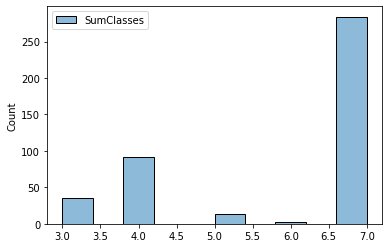

In [22]:
sns.histplot(df_classes)

In [23]:
pivot1 = pd.pivot_table(df_duplicates, index='ImageId', columns='ClassId', values='count', aggfunc = 'count', fill_value=0)
pivot1

ClassId,1,2,3,4
ImageId,,,,
0025bde0c.jpg,0,0,1,1
002fc4e19.jpg,1,1,0,0
008ef3d74.jpg,1,1,0,0
00ac8372f.jpg,1,1,0,0
00c88fed0.jpg,1,1,0,0
...,...,...,...,...
fd26ab9ad.jpg,0,0,1,1
fdb7c0397.jpg,0,0,1,1
fe2234ba6.jpg,1,0,1,0


In [24]:
pivot2 = pd.pivot_table(df_duplicates, index='ClassId', columns='ClassId', values='ImageId', aggfunc = 'count', fill_value=0)
pivot2

ValueError: Grouper for 'ClassId' not 1-dimensional

In [ ]:
pivot1[1]=pivot1[1].astype(int)

In [ ]:

ax = df.T.plot(kind='hist', ylabel='ClassId')

In [ ]:
result = pd.merge(df_classes, pivot1, on="ImageId")
result.head()

In [ ]:
result.info

In [ ]:
#df.astype(int).T.dot(df)
result.rename(columns={1: '1',2: '2',3: '3',4: '4'}, inplace=True)
#temp = result.columns.values.tolist()
temp = result[['1','2','3','4']]
a= temp.T.dot(temp)
a
#temp